In [65]:
from vibdata.raw import MFPT_raw, CWRU_raw

root_dir = "data"  # Where to save and load datasets
D = CWRU_raw(root_dir, download=True)  # Downloads the dataset if not available

# print(D.getMetaInfo())  # Prints metainfo of the dataset
# print("Number of signals:", len(D))

# Get the temporal signal and the respectively sample rate
signal = D[0]
signal_metainfo = D.getMetaInfo().iloc[0]
print("Length of signal:", len(signal))
print("Shape of signal:", signal["signal"][0].shape)
print("Label of signal:", signal["metainfo"])
print("Length of signal:", len(signal))
print("Signal sample rate:", signal_metainfo["sample_rate"])
signal["metainfo"]

Length of signal: 2
Shape of signal: (243938,)
Label of signal:    fault_size  load file_name  ... label sample_rate component_location
0         0.0   0.0    97.mat  ...     0       12000                NaN

[1 rows x 11 columns]
Length of signal: 2
Signal sample rate: 12000


,fault_size,load,file_name,variable_name,axis,domain,sample_size,rotation_hz,label,sample_rate,component_location
0,0.0,0.0,97.mat,X097_DE_time,DE,time,243938,29.95,0,12000,NaN


Metainfos

In [67]:
D.getMetaInfo()

,fault_size,load,file_name,variable_name,axis,domain,sample_size,rotation_hz,label,sample_rate,component_location
0,0.000,0.0,97.mat,X097_DE_time,DE,time,243938,29.950000,0,12000,NaN
1,0.000,0.0,97.mat,X097_FE_time,FE,time,243938,29.950000,0,12000,NaN
2,0.000,1.0,98.mat,X098_DE_time,DE,time,483903,29.533333,0,12000,NaN
3,0.000,1.0,98.mat,X098_FE_time,FE,time,483903,29.533333,0,12000,NaN
4,0.000,2.0,99.mat,X099_DE_time,DE,time,485063,29.166667,0,12000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
289,0.021,1.0,263.mat,X263_FE_time,FE,time,486224,29.533333,2,48000,DE
290,0.021,2.0,264.mat,X264_DE_time,DE,time,486804,29.166667,2,48000,DE
291,0.021,2.0,264.mat,X264_FE_time,FE,time,486804,29.166667,2,48000,DE
292,0.021,3.0,265.mat,X265_DE_time,DE,time,486224,28.833333,2,48000,DE


In [66]:
D.getMetaInfo(labels_as_str=True)

,fault_size,load,file_name,variable_name,axis,domain,sample_size,rotation_hz,label,sample_rate,component_location
0,0.000,0.0,97.mat,X097_DE_time,DE,time,243938,29.950000,Normal,12000,NaN
1,0.000,0.0,97.mat,X097_FE_time,FE,time,243938,29.950000,Normal,12000,NaN
2,0.000,1.0,98.mat,X098_DE_time,DE,time,483903,29.533333,Normal,12000,NaN
3,0.000,1.0,98.mat,X098_FE_time,FE,time,483903,29.533333,Normal,12000,NaN
4,0.000,2.0,99.mat,X099_DE_time,DE,time,485063,29.166667,Normal,12000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
289,0.021,1.0,263.mat,X263_FE_time,FE,time,486224,29.533333,Outer Race,48000,DE
290,0.021,2.0,264.mat,X264_DE_time,DE,time,486804,29.166667,Outer Race,48000,DE
291,0.021,2.0,264.mat,X264_FE_time,FE,time,486804,29.166667,Outer Race,48000,DE
292,0.021,3.0,265.mat,X265_DE_time,DE,time,486224,28.833333,Outer Race,48000,DE


Building a data filter

In [6]:
import yaml

def load_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

def filter_data(metadata, filter_config):
    indexes_metainfo = []

    for index, row in metadata.iterrows():
        matches = all(
            row[key] in value if isinstance(value, list) 
            else row[key] == value for key, value in filter_config.items()
        )
        if matches:
            indexes_metainfo.append(index)
    
    return indexes_metainfo


# Get dataset info
D = CWRU_raw(root_dir)
metainfo = D.getMetaInfo(labels_as_str=True)

# load filter configuration of CWRU
filter_config_cwru = load_config('configs/filters_config.yaml')['CWRU']

# Filtering the data    
indexes = filter_data(metainfo, filter_config_cwru)

filtered_data = D[indexes]
len(filtered_data["signal"])

0

Transforming the data

In [59]:
from vibdata.deep.DeepDataset import DeepDataset, convertDataset
import vibdata.raw as raw_datasets
from vibdata.deep.signal.transforms import Spectrogram, FilterByValue, Sequential

def build_transforms(filter_config, spect_config):
    # Get the transforms to be applied

    return Sequential(
        [ 
            FilterByValue(on_field, values) for on_field, values in filter_config.items() 
        ] + [
            Spectrogram(**spect_config)
        ]
    )

def transform_dataset(dataset_name, raw_root_dir, deep_root_dir, transforms):
    raw_dataset = getattr(raw_datasets, dataset_name + "_raw")(raw_root_dir, download=True)

    convertDataset(dataset=raw_dataset, transforms=transforms, dir_path=deep_root_dir)
    # Load the dataset which has been converted
    return DeepDataset(deep_root_dir)


Função responsável por plotar o espectrograma

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram(metainfo, Sxx):
    delta_t = metainfo["delta_t"]
    delta_f = metainfo["delta_f"]
    
    # Determinar as escalas dos eixos de tempo e frequência
    num_time_steps = Sxx.shape[1]
    num_freq_bins = Sxx.shape[0]
    time_extent = [0, delta_t * num_time_steps]
    freq_extent = [0, delta_f * num_freq_bins]

    # Plot do espectrograma
    fig = plt.figure(figsize=(10, 6))
    plt.imshow(np.fliplr(abs(Sxx).T).T, aspect='auto', cmap='viridis', 
               extent=[time_extent[0], time_extent[1], freq_extent[0], freq_extent[1]])
    # plt.imshow(np.log(np.abs(Sxx[: 382, :]**2)), cmap='jet',
    #            extent=[time_extent[0], time_extent[1], freq_extent[0], freq_extent[1]])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label="Power/Frequency (dB/Hz)")
    plt.title("Spectrogram")
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.show()


Cria os espectrogramas

In [41]:
def create_spectrogram(dataset):
    for d in dataset:
        # Calculate the spectrogram
        metainfo = d['metainfo']
        Sxx = d['signal'][0]
        plot_spectrogram(metainfo, Sxx)
    

Rodando os scripts para criação dos espectrogramas

Transformando


Converting CWRU: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s]


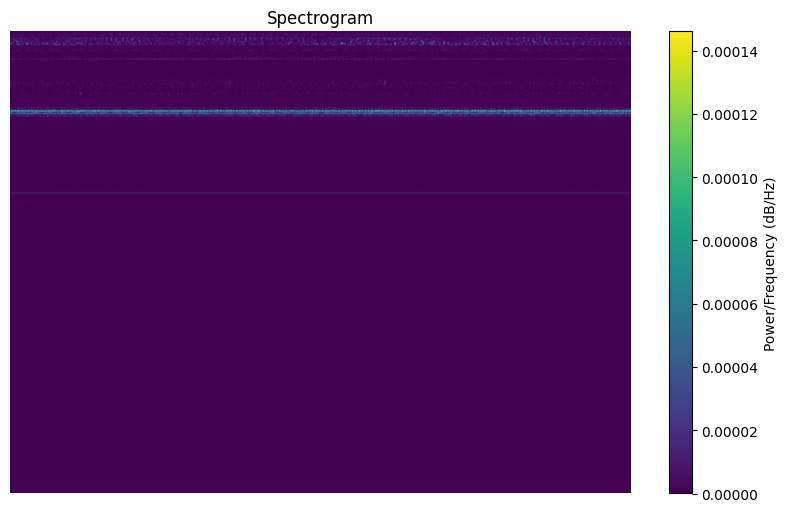

In [60]:
dataset_name = "CWRU"
raw_root_dir = "data"
deep_root_dir = "data/deep_dataset0"

filter_config = load_config('configs/filters_config.yaml')[dataset_name]
spect_config = load_config('configs/spectrogram_config.yaml')[dataset_name]

transforms = build_transforms(filter_config, spect_config)
dataset = transform_dataset(dataset_name, raw_root_dir, deep_root_dir, transforms)
create_spectrogram(dataset)

In [109]:
signal_metainfo = D.getMetaInfo(labels_as_str=True)
D[100]['metainfo']
D.__class__.__name__[:-4]

'CWRU'

In [46]:
from vibdata.deep.DeepDataset import DeepDataset, convertDataset
import vibdata.raw as raw_datasets
from vibdata.deep.signal.transforms import Spectrogram, Sequential

dataset_name = "CWRU"

# Get raw root_dir
raw_root_dir = "data"
raw_dataset = getattr(raw_datasets, dataset_name + "_raw")(raw_root_dir, download=True)

deep_root_dir = "deep_dataset"
# Get the transforms to be applied
transforms = Sequential(
    [
        Spectrogram() # 12kHz
    ]
)

# Convert the raw dataset to deepdataset 
# Deep dataset is the dataset compatible with pytorch
convertDataset(dataset=raw_dataset, transforms=transforms, dir_path=deep_root_dir)
# Load the dataset which has been converted
dataset = DeepDataset(deep_root_dir)
dataset[100]["signal"][0].shape

Transformando


Converting CWRU: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


(129, 539)

129 539


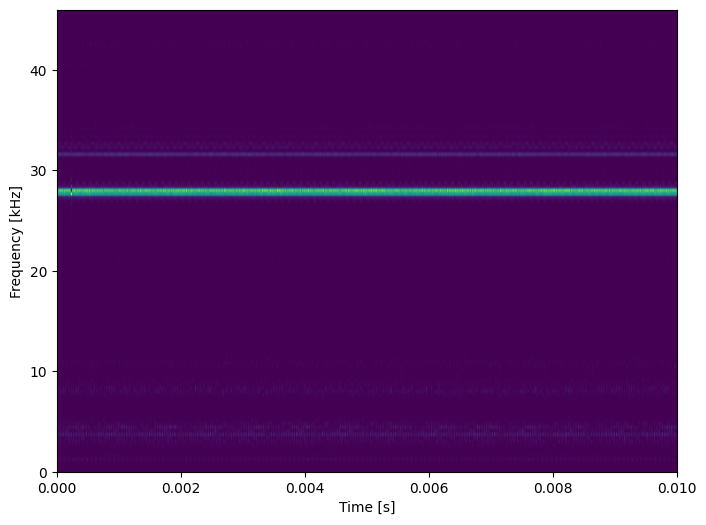

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Exemplo de visualização do primeiro espectrograma
Sxx = dataset[100]['signal'][0]  # Primeiro espectrograma
f = np.linspace(0, 46, Sxx.shape[0])  # Frequências
t = np.linspace(0, 0.01, Sxx.shape[1])  # Tempos (ajuste conforme necessário)

print(Sxx.shape[0], Sxx.shape[1])

plt.figure(figsize=(8, 6))
plt.imshow(np.fliplr(abs(Sxx).T).T, cmap='viridis', aspect='auto',
            extent=[t.min(), t.max(), f.min(), f.max()])
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [s]')
plt.show()